# Part I - GoBike Usage Analysis
## by Karoline Sears

## Introduction
> Bike share programs are a popular mode of transportation in large cities. The Ford GoBike system in San Francisco, California is a growing fleet managed by the __[Metropolitan Transportation Commission](https://mtc.ca.gov/tags/ford-gobike)__. This analysis will explore who is using the bikeshare program, where it's being used, and any other interesting information about the program.


## Preliminary Wrangling


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

df = pd.read_csv('201902-fordgobike-tripdata.csv')
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [2]:
df.shape

(183412, 16)

In [3]:
#a quick review of the fields and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
duration_sec               183412 non-null int64
start_time                 183412 non-null object
end_time                   183412 non-null object
start_station_id           183215 non-null float64
start_station_name         183215 non-null object
start_station_latitude     183412 non-null float64
start_station_longitude    183412 non-null float64
end_station_id             183215 non-null float64
end_station_name           183215 non-null object
end_station_latitude       183412 non-null float64
end_station_longitude      183412 non-null float64
bike_id                    183412 non-null int64
user_type                  183412 non-null object
member_birth_year          175147 non-null float64
member_gender              175147 non-null object
bike_share_for_all_trip    183412 non-null object
dtypes: float64(7), int64(2), object(7)
memory usage: 22.4+ MB


### What is the structure of your dataset?

There are 18,3412 records in this dataframe depicting usage data. Data collected includes duration of use, start and end locations of the bikes, and demographic information about the user. The rental check-outs all took place in the month of February 2019.


### What is/are the main feature(s) of interest in your dataset?

I want to know who is using the bikeshare program and when/under what circumstances.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

Asking these questions of the data provided should be able to give me an idea of who is using the program and where:
*  User demographics, such as gender identity and user type (customer/subscriber).
*  Rental details, such as duration, day of the week, time of day.

## Quick Clean of the Data

After a brief review of the data, I need to fix the data types for any data that is related to a date field. In this case, the 'start time' and 'end time' are all not classified as timestamps/dates. Rather, the 'start time' and 'end time' fields are string objects.

In [2]:
df_clean = df.copy()
df_clean ['start_time'] = pd.to_datetime(df['start_time'])
df_clean ['end_time'] = pd.to_datetime(df['end_time'])

In [17]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
duration_sec               183412 non-null int64
start_time                 183412 non-null datetime64[ns]
end_time                   183412 non-null datetime64[ns]
start_station_id           183215 non-null float64
start_station_name         183215 non-null object
start_station_latitude     183412 non-null float64
start_station_longitude    183412 non-null float64
end_station_id             183215 non-null float64
end_station_name           183215 non-null object
end_station_latitude       183412 non-null float64
end_station_longitude      183412 non-null float64
bike_id                    183412 non-null int64
user_type                  183412 non-null object
member_birth_year          175147 non-null float64
member_gender              175147 non-null object
bike_share_for_all_trip    183412 non-null object
dtypes: datetime64[ns](2), float64(7), int64(2), object(5)
memory us

## Univariate Exploration

### User Profiles

Who are the people participating in the bikeshare program?
* Gender identity
* Subscriber vs Customer (User Type)
* Ages

### Rental Profile

How and when are the bikes being used?

* Duration of rental
* Day of week of rental
* Time of day of rental

In [3]:
#Day of the week is categorical, so I need to set that up early on.
df_clean['day_of_rental'] = df_clean['start_time'].dt.day_name()

ordinal_var_dict = {'day_of_rental': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    df_clean[var] = df_clean[var].astype(ordered_var)


## User Profiles

### Gender Identity

In [4]:
df_clean['member_gender'].value_counts()

Male      130651
Female     40844
Other       3652
Name: member_gender, dtype: int64

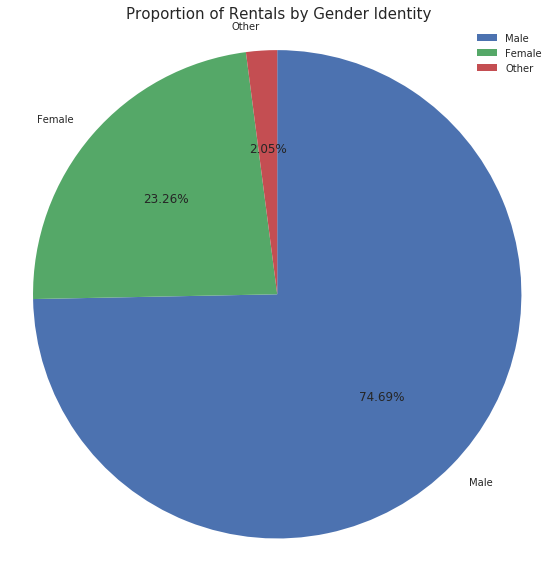

In [82]:
sorted_counts = df_clean['member_gender'].value_counts()
null_gender = df_clean['member_gender'].value_counts().sum()
max_type_count = sorted_counts[0]
max_prop = max_type_count/null_gender

plt.pie(sorted_counts, labels = sorted_counts.index, autopct='%1.2f%%', startangle = 90, counterclock = False);
plt.legend(sorted_counts.index, loc="best")
plt.title("Proportion of Rentals by Gender Identity", fontsize = 15)
plt.axis('square');

> There are clearly more users identifying as male than any other gender identity.

### User Type

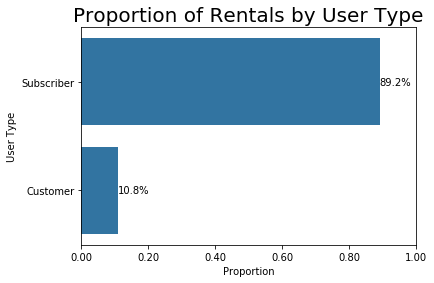

In [8]:
type_counts = df_clean['user_type'].value_counts()
type_order = type_counts.index
base_color = sb.color_palette()[0]


null_users = df_clean['user_type'].value_counts().sum()
max_type_count = type_counts[0]
max_prop = max_type_count/null_users
tick_props = np.arange(0, max_prop+0.2, 0.2)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]


sb.countplot(data = df_clean, y = 'user_type', color = base_color, order = type_order);
plt.xticks(tick_props * null_users, tick_names)
plt.xlabel('Proportion')
plt.ylabel('User Type')
plt.title('Proportion of Rentals by User Type', fontsize = 20);

for i in range (type_counts.shape[0]):
    count = type_counts[i]
    pct_string = '{:0.1f}%'.format(100*count/null_users)
    plt.text(count+1, i, pct_string, va='center')


> Users are overwhelmingly Subscribers

### Ages

In [9]:
#This is tricky because there are some obviously wrong ages here due to likely typos in the birth year column.
#while there certainly may be older patrons, I think it is safe to not include anyone older than 80 (1939 in 2019),
# but they should not be included in the calculations.
too_old = df_clean.query('member_birth_year < 1939')
too_old['member_birth_year'].count()

192

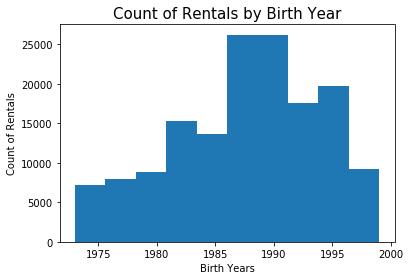

In [10]:
THRESHOLD = 1939
year_frequency = df_clean['member_birth_year'].value_counts()
idx = np.sum(year_frequency > THRESHOLD)
most_years = year_frequency.index[:idx]
member_year_sub = df_clean.loc[df_clean['member_birth_year'].isin(most_years)]
year_means = member_year_sub.groupby('member_birth_year').mean()
plt.hist(data = member_year_sub, x = 'member_birth_year');
plt.xlabel('Birth Years');
plt.ylabel('Count of Rentals');
plt.title('Count of Rentals by Birth Year', fontsize = 15);


> Users skew younger, between 20-40 years of age.

## Rental Profiles

### What is the duration of each rental?

In [11]:
#average duration of booking in minutes
duration_mean = df_clean['duration_sec'].mean()
duration_mean/60

12.101307257249617

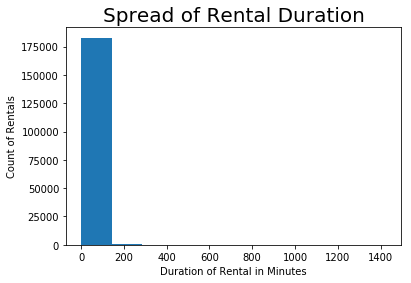

In [12]:
#What is the spread of the rental duration in minutes?
rental_minutes = df_clean['duration_sec']/60
plt.hist(data = df_clean, x = rental_minutes);
plt.xlabel('Duration of Rental in Minutes');
plt.ylabel('Count of Rentals');
plt.title('Spread of Rental Duration', fontsize = 20);

In [10]:
#taking a closer look
np.log10(rental_minutes.describe())

count    5.263428
mean     1.082832
std      1.475766
min      0.007179
25%      0.733732
50%      0.932812
75%      1.122762
max      3.153530
Name: duration_sec, dtype: float64

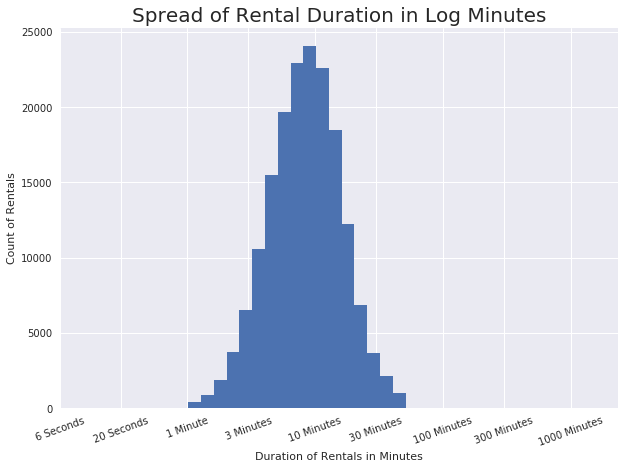

In [85]:
bins = 10 ** np.arange(0.007, 3.153+0.1, 0.1)

plt.figure(figsize=[10, 7])
plt.hist(data = df_clean, x = rental_minutes, bins = bins);
plt.xscale('log');
plt.xticks([0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000], ['6 Seconds', '20 Seconds', '1 Minute', '3 Minutes', 
                                                   '10 Minutes', '30 Minutes', '100 Minutes', 
                                                   '300 Minutes', '1000 Minutes']);
plt.xlabel('Duration of Rentals in Minutes');
plt.xticks(rotation = 20)
plt.ylabel('Count of Rentals');
plt.title('Spread of Rental Duration in Log Minutes', fontsize = 20);

> It looks like most rentals are between 1 minute and 30 minutes in length, with a possible mean of about 10 minutes.

### What is the breakdown of rentals across each day of the week? (Day of Week)

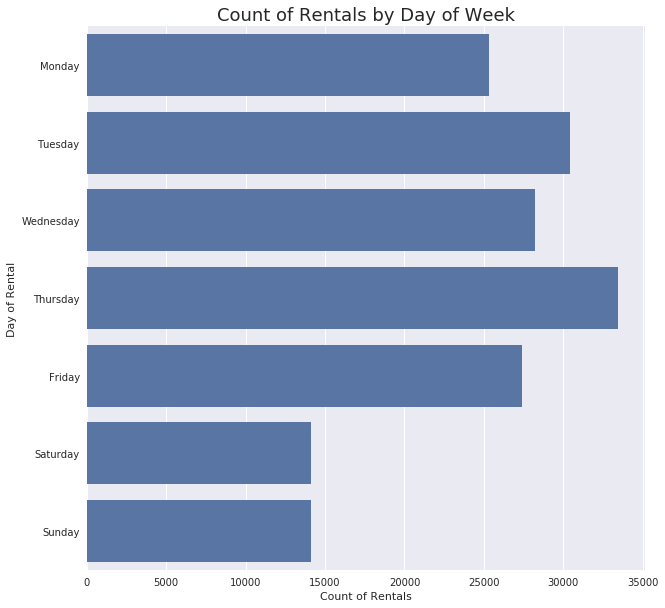

In [80]:
base_color = sb.color_palette()[0]
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sb.countplot(data = df_clean, y = 'day_of_rental', color = base_color, order = day_order);
plt.xlabel('Count of Rentals');
plt.ylabel('Day of Rental');
plt.title('Count of Rentals by Day of Week', fontsize = 18);

> The bikes look like they are most often used during the work-week.

### What is the breakdown of rentals across each day? (Time of Day)

In [13]:
df_clean['start_time'].dt.hour.value_counts()

17    21864
8     21056
18    16827
9     15903
16    14169
7     10614
19     9881
15     9174
12     8724
13     8551
10     8364
14     8152
11     7884
20     6482
21     4561
6      3485
22     2916
23     1646
0       925
5       896
1       548
2       381
4       235
3       174
Name: start_time, dtype: int64

In [14]:
#I will be using this variable again in the future, so I am making it a column in the table
df_clean['rental_hour'] = df_clean['start_time'].dt.hour

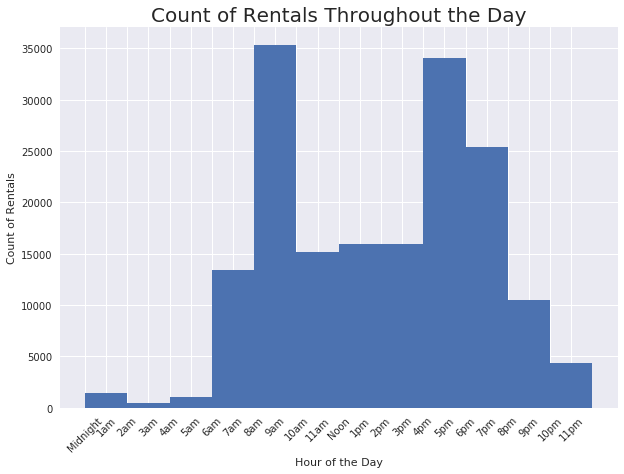

In [86]:
#I am simplifying the rental time into hour blocks
hour_counts = df_clean['rental_hour']
bins = np.arange(0, hour_counts.max()+2, 2)

plt.figure(figsize=[10, 7])
plt.hist(data = df_clean, x = hour_counts, bins = bins);
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,
            16,17,18,19,20,21,22,23], ['Midnight', '1am', '2am', '3am', '4am', '5am','6am', '7am',
                                       '8am', '9am','10am', '11am','Noon', '1pm','2pm', '3pm',
                                       '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm']);
plt.xticks(rotation = 45);
plt.ylabel('Count of Rentals');
plt.xlabel('Hour of the Day');
plt.title('Count of Rentals Throughout the Day', fontsize = 20);


> Rentals follow the bimodal shape of rush hour traffic, which makes sense considering the bikes are more often used during the work week.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

*  I am surprised by the breakdown of gender identity; while not ever rental had this demographic information, I was not expecting such a large proportion of men over women.

*  It was not surprising that the proportion of subscribers is significantly higher than casual users; I imagine that any company would want to have more subscribers.

*  The member ages was a tricky variable. Not every rental had this demographic information and over 100 of the rentals clearly had something wrong with the birth year (e.g., 1900). But, what is not surprising is that the data skews toward younger users. Biking is a physical activity and likely a strenuous one in a city such as San Francisco.

*  Rental duration was a variable that needed a closer look. Most rentals are under 30 minutes in length.

*  Rentals appear to take place more often during the week than on the weekend, which was a bit surprising to me. I would assume that, in a large city, bike usage would be somewhat uniform across the week.

*  The rental time of day makes sense when also thinking about the days of the week; If people are renting the bikes during the week to go to work, the bimodal visualization showing peaks in the morning and late afternoon line up with common rush hour traffic times. 

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

*  There were outliers associated with rental duration that made the initial visualization difficult to interpret. Knowing that the mean duration of rental was about 12 minutes, I knew there must be some kind of outlier(s) affecting the visual. By introducing a log transformation, I was able to zoom in on the data. 

## Bivariate Exploration

### User Types and Day of the Week Rentals

In [16]:
df_clean.groupby(['day_of_rental', 'user_type'], as_index=False)['start_time'].count()

,day_of_rental,user_type,start_time
0,Monday,Customer,2741
1,Monday,Subscriber,24111
2,Tuesday,Customer,2606
3,Tuesday,Subscriber,29207
4,Wednesday,Customer,2466
5,Wednesday,Subscriber,27175
6,Thursday,Customer,3390
7,Thursday,Subscriber,31807
8,Friday,Customer,3030
9,Friday,Subscriber,25951


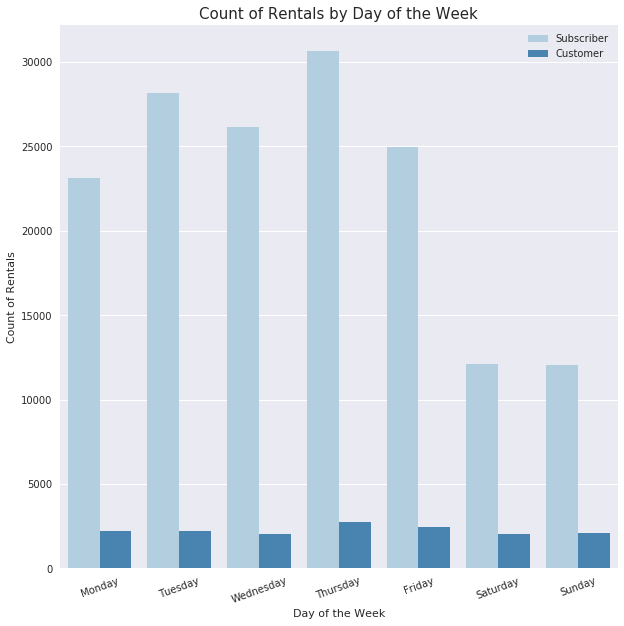

In [87]:
#Looks like the rate of use is similar between the two types of customers
ax = sb.countplot(data = df_clean, x = 'day_of_rental', hue = 'user_type', palette = 'Blues');
ax.legend(loc = 1, framealpha = 1)
plt.xlabel('Day of the Week');
plt.ylabel('Count of Rentals');
plt.title('Count of Rentals by Day of the Week', fontsize = 15)
plt.xticks(rotation = 20);

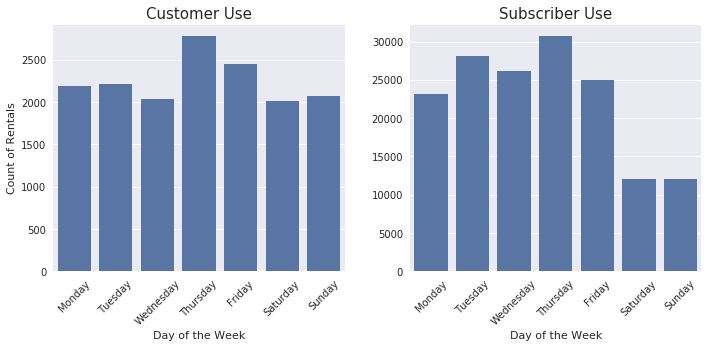

In [88]:
#since the sheer number of rentals by subscribers is so much more than customers,
#I want to zoom in a bit to see if there is a difference in use patterns
fig, ax = plt.subplots(1, 2, sharey = True, figsize=(10, 5))

# Customer use over the span of a week
plt.subplot(1, 2, 1) 
base_color = sb.color_palette()[0]
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sb.countplot(data = df_clean.query('user_type == "Customer"'), x = 'day_of_rental', 
                  color = base_color, order = day_order);
ax.legend(loc = 1, framealpha = 1)
plt.xlabel('Day of the Week');
plt.ylabel('Count of Rentals');
plt.title('Customer Use', fontsize = 15);
plt.xticks(rotation = 45);

# Subscriber use over the span of a week
plt.subplot(1, 2, 2)
base_color = sb.color_palette()[0]
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sb.countplot(data = df_clean.query('user_type == "Subscriber"'), x = 'day_of_rental', 
                  color = base_color, order = day_order);
ax.legend(loc = 1, framealpha = 1)
plt.xlabel('Day of the Week');
plt.ylabel(" ");
plt.title('Subscriber Use', fontsize = 15);
plt.xticks(rotation = 45);

fig.tight_layout()

> It is much more obvious in the above visualization that there is a difference in how Customers use the bikes compared to Subscribers. Customers are using the bikes fairly consistently throughout the week while Subscribers are clearly using the bikes during the week more than on weekends.

### User Type and Rental Duration

In [21]:
#Since I will be using this calculation again, I will make it a column
df_clean['rental_minutes'] = df_clean['duration_sec']/60

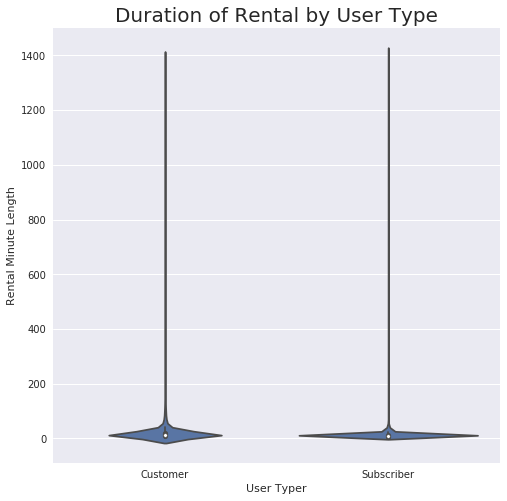

In [22]:
#these violin plots are clearly being influenced by some big outliers
base_color = sb.color_palette()[0]
sb.set(rc={"figure.figsize":(8, 8)})
sb.violinplot(data = df_clean, x = 'user_type', y = 'rental_minutes',
                  color = base_color);
plt.ylabel('Rental Minute Length');
plt.xlabel('User Typer');
plt.title('Duration of Rental by User Type', fontsize = 20);

In [23]:
#Since the mean rental time is 12 minutes and looking at the visualization from earlier, 
#I am going to see what our outliers look like for rentals over 50 minutes
outlier_minutes = (df_clean['rental_minutes'] > 50)
#print(outlier_minutes.sum())
#print(df_clean.loc[outlier_minutes, :])

In [24]:
#remove those outliers
df_clean = df_clean.loc[-outlier_minutes, :]

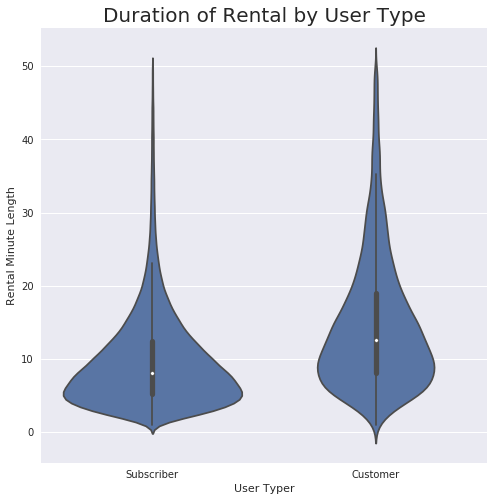

In [25]:
#re-plot the data
base_color = sb.color_palette()[0]
sb.set(rc={"figure.figsize":(8, 8)})
sb.violinplot(data = df_clean, x = 'user_type', y = 'rental_minutes',
                  color = base_color);
plt.ylabel('Rental Minute Length');
plt.xlabel('User Typer');
plt.title('Duration of Rental by User Type', fontsize = 20);

In [26]:
#I want to transform this now because I am going to be using this variable a bit more
def log_trans(x, inverse = False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)

df_clean['log_duration'] = df_clean['rental_minutes'].apply(log_trans)

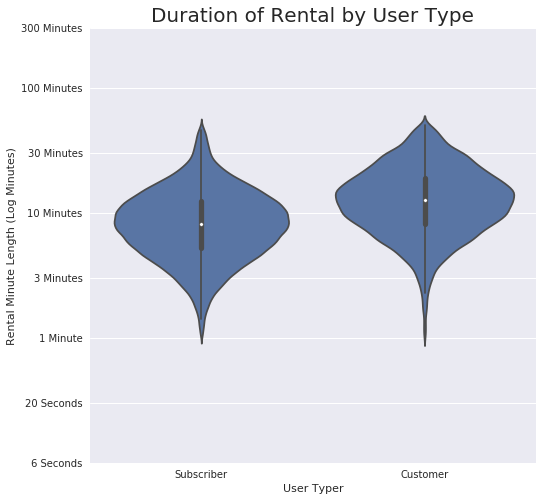

In [13]:
base_color = sb.color_palette()[0]
sb.set(rc={"figure.figsize":(8, 8)})

ax = sb.violinplot(data = df_clean, x = 'user_type', y = 'log_duration', color = base_color, showmeans = True)

ax.set_yticks(log_trans(np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])))
ax.set_yticklabels(['6 Seconds', '20 Seconds', '1 Minute', '3 Minutes', 
                                                   '10 Minutes', '30 Minutes', '100 Minutes', 
                                                   '300 Minutes'])
plt.ylabel('Rental Minute Length (Log Minutes)');
plt.xlabel('User Typer');
plt.title('Duration of Rental by User Type', fontsize = 20);

> Looks like Subscribers like to use the bikes for quick purposes more than Customers.

### Day of the Week and Rental Duration

In [27]:
df_clean['rental_minutes'].describe()

count    181090.000000
mean         10.245153
std           7.043332
min           1.016667
25%           5.383333
50%           8.483333
75%          13.016667
max          50.000000
Name: rental_minutes, dtype: float64

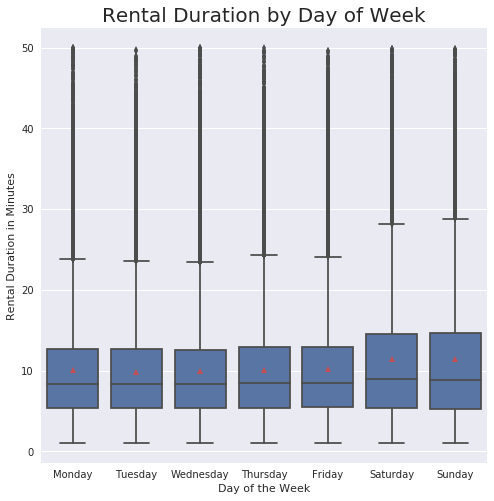

In [28]:
#This boxplot really demonstrates how many outliers still exist over 30 minutes
base_color = sb.color_palette()[0]
sb.boxplot(data = df_clean, x='day_of_rental', y='rental_minutes', color=base_color, showmeans = True);
plt.xlabel('Day of the Week');
plt.ylabel('Rental Duration in Minutes');
plt.title('Rental Duration by Day of Week', fontsize = 20);


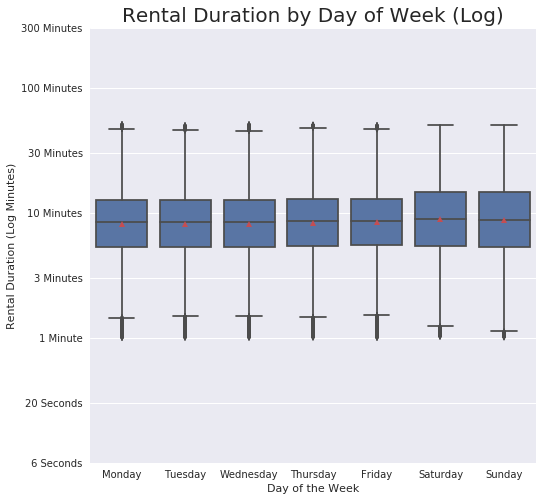

In [29]:
#transform and zoom in more
base_color = sb.color_palette()[0]
ax = sb.boxplot(data = df_clean, x='day_of_rental', y='log_duration', color=base_color, showmeans = True);
ax.set_yticks(log_trans(np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])))
ax.set_yticklabels(['6 Seconds', '20 Seconds', '1 Minute', '3 Minutes', 
                                                   '10 Minutes', '30 Minutes', '100 Minutes', 
                                                   '300 Minutes'])
plt.xlabel('Day of the Week');
plt.ylabel('Rental Duration (Log Minutes)');
plt.title('Rental Duration by Day of Week (Log)', fontsize = 20);

This visual demonstrates how use during the week is quite consistent, but there is some spread on the weekends. Likely influenced by the different types of users (Customers vs. Subscribers).

### Gender Identity and Age

In [30]:
#Adding a column that has the calculated age of each person
df_clean['age'] = 2019 - df_clean['member_birth_year']

In [31]:
#Convert the age data type from float to integer
df_clean['age'] = df_clean['age'].fillna(0)
df_clean['age'] = df_clean['age'].astype(int)

In [32]:
#Sticking with my threshold of 1939 I need to remove those ages that are outliers
outlier_age = (df_clean['age'] > 80)
#print(outlier_age.sum())
#print(df_clean.loc[outlier_age, :])

In [33]:
no_age = (df_clean['age'] == 0)
#print(no_age.sum())
#print(df_clean.loc[no_age, :])

In [34]:
#remove those outliers
df_clean = df_clean.loc[-outlier_age & -no_age, :]

member_gender
Female    31
Male      32
Other     34
Name: age, dtype: int64
member_gender
Female    33.165043
Male      34.366279
Other     35.707875
Name: age, dtype: float64


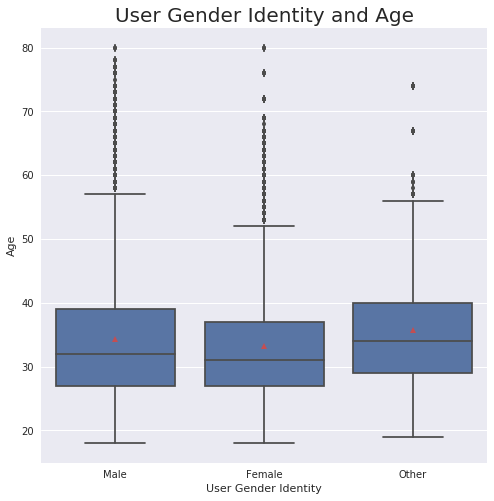

In [35]:
#Build the plot. I am also indicating the mean on the boxplots with the red triangle.
base_color = sb.color_palette()[0]
orders = df_clean['member_gender'].value_counts().index
sb.boxplot(data = df_clean, x='member_gender', y='age', order = orders, color=base_color, showmeans = True);
plt.xlabel('User Gender Identity');
plt.ylabel('Age');
plt.title('User Gender Identity and Age', fontsize = 20);

median_age = df_clean.groupby('member_gender')['age'].median()
mean_age = df_clean.groupby('member_gender')['age'].mean()
print(median_age)
print(mean_age)

> While the mean and median ages of each group is quite similar, this boxplot shows how the female-identifying group is generally younger.

### Gender Identity and Duration of Use

In [36]:
#I want to check my means here first
gender_rentals = df_clean.groupby('member_gender')['rental_minutes'].mean()
gender_rentals

member_gender
Female    11.077640
Male       9.872383
Other     11.028173
Name: rental_minutes, dtype: float64

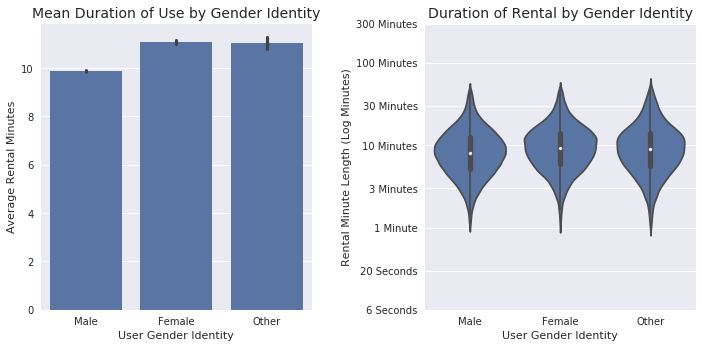

In [37]:
#Plotting the visuals
fig, ax = plt.subplots(2, 1, figsize = [10,5])

#Mean duration of use by gender identity
plt.subplot(1, 2, 1) 
base_color = sb.color_palette()[0]
sb.barplot(data = df_clean, x = 'member_gender', y = 'rental_minutes', color=base_color);
plt.ylabel('Average Rental Minutes');
plt.xlabel('User Gender Identity');
plt.title('Mean Duration of Use by Gender Identity', fontsize = 14);

#Duration of use by gender identity, using log transformation
plt.subplot(1, 2, 2) 
base_color = sb.color_palette()[0]

ax = sb.violinplot(data = df_clean, x = 'member_gender', y = 'log_duration', color = base_color)

ax.set_yticks(log_trans(np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])))
ax.set_yticklabels(['6 Seconds', '20 Seconds', '1 Minute', '3 Minutes', 
                                                   '10 Minutes', '30 Minutes', '100 Minutes','300 Minutes'])
plt.ylabel('Rental Minute Length (Log Minutes)');
plt.xlabel('User Gender Identity');
plt.title('Duration of Rental by Gender Identity', fontsize = 14);
fig.tight_layout()

> Female-and other-identifying users rent the bikes (on average) for longer than the male-identifying group. 

### Gender Identity and Day of the Week

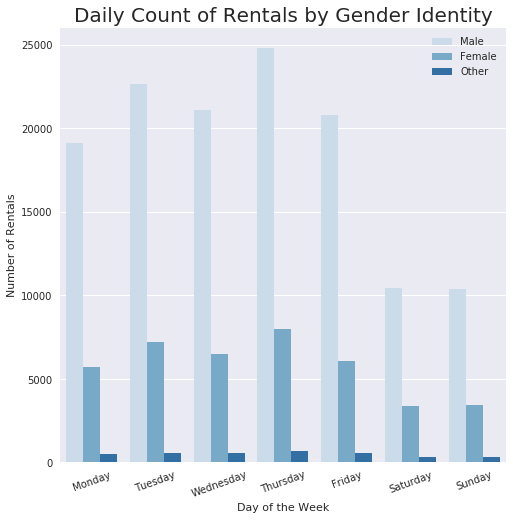

In [96]:
#plotting with a clustered bar chart to compare. The sheer number of rentals by male users is so high
#it takes away from my ability to see if there are trends. I need to look at this differently.
ax = sb.countplot(data = df_clean, x = 'day_of_rental', hue = 'member_gender', palette = 'Blues');
ax.legend(loc = 1, framealpha = 1)
plt.xlabel('Day of the Week');
plt.ylabel('Number of Rentals');
plt.xticks(rotation = 20);
plt.title('Daily Count of Rentals by Gender Identity', fontsize = 20);

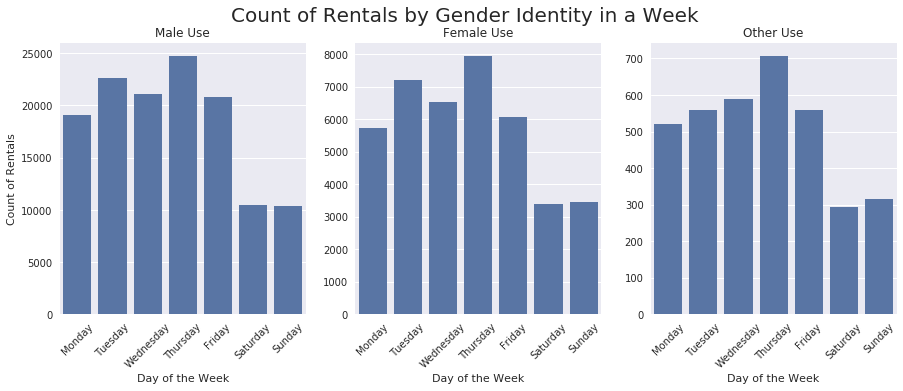

In [97]:
fig, ax = plt.subplots(3, 1, figsize=(15, 5))
fig.suptitle('Count of Rentals by Gender Identity in a Week', fontsize=20);

# males
plt.subplot(1, 3, 1) 
base_color = sb.color_palette()[0]
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sb.countplot(data = df_clean.query('member_gender == "Male"'), x = 'day_of_rental', 
                  color = base_color, order = day_order);
plt.legend(loc = 1, framealpha = 1)
plt.xlabel('Day of the Week');
plt.ylabel('Count of Rentals');
plt.title('Male Use');
plt.xticks(rotation = 45);

# females
plt.subplot(1, 3, 2)
base_color = sb.color_palette()[0]
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sb.countplot(data = df_clean.query('member_gender == "Female"'), x = 'day_of_rental', 
                  color = base_color, order = day_order);
plt.legend(loc = 1, framealpha = 1)
plt.xlabel('Day of the Week');
plt.ylabel(' ');
plt.title('Female Use');
plt.xticks(rotation = 45);

# other
plt.subplot(1, 3, 3) 
base_color = sb.color_palette()[0]
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sb.countplot(data = df_clean.query('member_gender == "Other"'), x = 'day_of_rental', 
                  color = base_color, order = day_order);
plt.legend(loc = 1, framealpha = 1)
plt.xlabel('Day of the Week');
plt.ylabel(' ');
plt.title('Other Use');
plt.xticks(rotation = 45);

>The use across each day of the week is comparable among the three identities. There is a slight uptick in use on Sundays for both females and other, but nothing drastic.

### Gender Identity and User Type

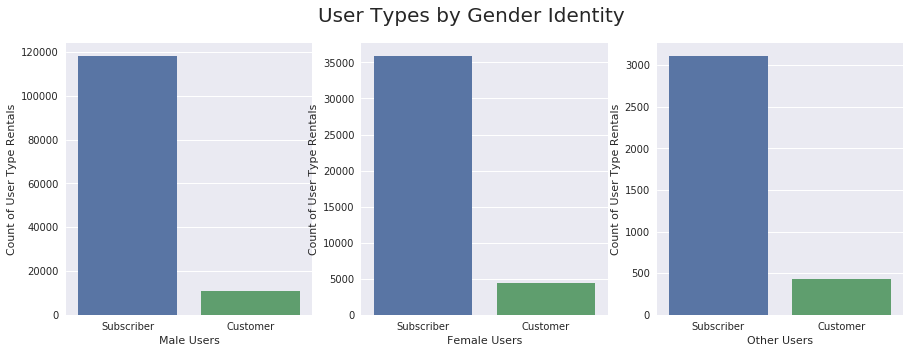

In [98]:
#I originally tried a sharey here, but decided not to keep it, as it made it difficult to see the difference
#in customer type within each gender identity.
fig, ax = plt.subplots(1,3, figsize=(15, 5))

fig.suptitle('User Types by Gender Identity', fontsize=20);

# males
plt.subplot(1, 3, 1)  
sb.countplot(data = df_clean.query('member_gender == "Male"'), x = 'user_type');
plt.ylabel('Count of User Type Rentals');
plt.xlabel('Male Users');

# females
plt.subplot(1, 3, 2)
sb.countplot(data = df_clean.query('member_gender == "Female"'), x = 'user_type');
plt.ylabel('Count of User Type Rentals');
plt.xlabel('Female Users');

# other
plt.subplot(1, 3, 3)
sb.countplot(data = df_clean.query('member_gender == "Other"'), x = 'user_type');
plt.ylabel('Count of User Type Rentals');
plt.xlabel('Other Users');

> There are consistently more Subscribers than Customers, regardless of gender identity.

### Age Groupings and Rental Duration

In [40]:
#I need to create age groupings for my bin edges
bin_edges=[10, 20, 30, 40, 50, 60, 70, 80]
bin_names=['Under 20', '20s', '30s', '40s', '50s', '60s', '70s']
df_clean['age_group']=pd.cut(df_clean['age'], bin_edges, labels=bin_names)
df_clean['age_group'].value_counts()

20s         69324
30s         63311
40s         21776
50s         11158
Under 20     4166
60s          2916
70s           374
Name: age_group, dtype: int64

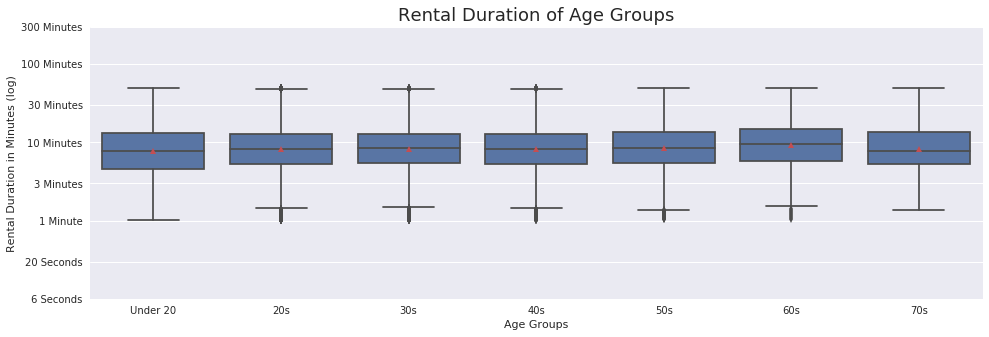

In [99]:
#Age and duration
plt.figure(figsize = [16, 5])
base_color = sb.color_palette()[0]
ax = sb.boxplot(data = df_clean, x='age_group', y='log_duration', color=base_color, showmeans = True);
ax.set_yticks(log_trans(np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])))
ax.set_yticklabels(['6 Seconds', '20 Seconds', '1 Minute', '3 Minutes','10 Minutes', '30 Minutes', 
                    '100 Minutes','300 Minutes'])

plt.xlabel('Age Groups');
plt.ylabel('Rental Duration in Minutes (log)');
plt.title('Rental Duration of Age Groups', fontsize = 18);

> Each age group seems to be sticking fairly closely to the 10 minute range. Even in the visualization below, which demonstrates the spread with the mean, use appears consistent.

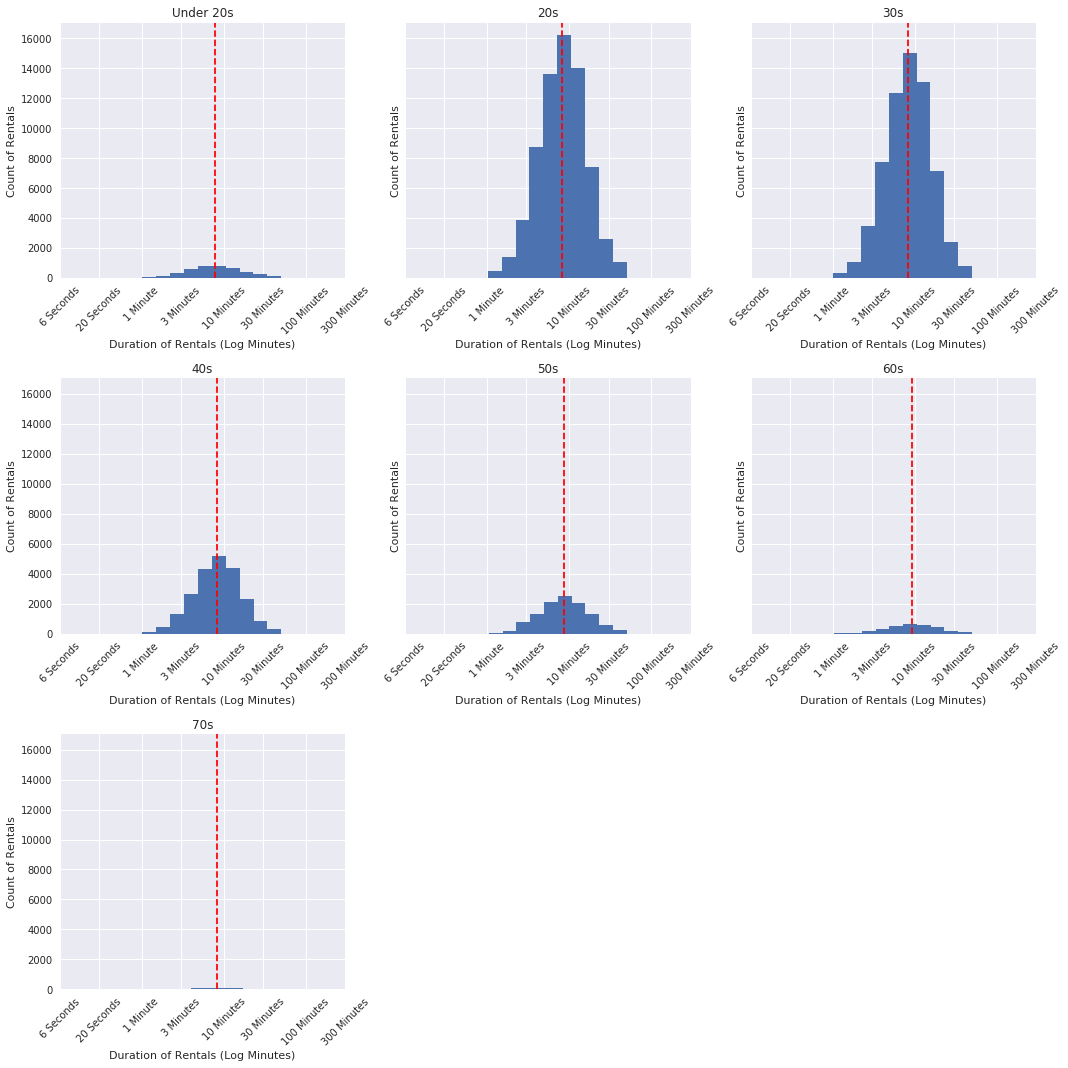

In [100]:
g = sb.FacetGrid(data = df_clean, col = 'age_group', size = 5, col_wrap = 3, margin_titles = True)

def plot_mean(log_duration,**kwargs):
    m = log_duration.mean()
    plt.axvline(m, **kwargs)

g.map(plt.hist, "log_duration")
g.set(xticks = log_trans(np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])))
g.set(xticklabels = (['6 Seconds', '20 Seconds', '1 Minute', '3 Minutes','10 Minutes', '30 Minutes', 
                    '100 Minutes','300 Minutes']))

titles = ['Under 20s', '20s', '30s', '40s', '50s', '60s', '70s']

g.map(plot_mean, 'log_duration', color="red", linestyle="dashed") 

axes = g.axes.flatten()
for ax,title in zip(g.axes.flatten(),titles):
    ax.set_title(title)
    ax.set_xlabel("Duration of Rentals (Log Minutes)")
    ax.set_ylabel("Count of Rentals")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    for tick in ax.get_xticklabels():
        tick.set_visible(True)
    
plt.tight_layout()

> Looking at the standard deviation (spread) of the data by age group shows much more clearly where there is variance across the different age groups. The users under the age of 20 rent the bikes with more variation.

In [43]:
#standard deviation by age group shows that there is more spread among the under-20 group
df_clean.groupby('age_group')['log_duration'].std()

age_group
Under 20    0.332493
20s         0.282566
30s         0.276143
40s         0.282199
50s         0.294988
60s         0.290998
70s         0.286334
Name: log_duration, dtype: float64

0.918029869107
10.1764231566


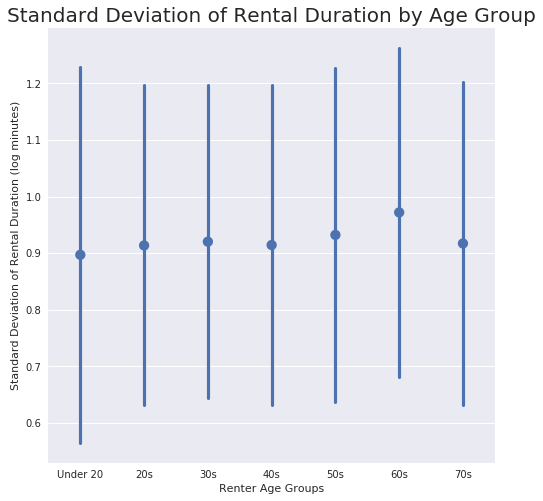

In [101]:
#that spread is visible here
ax = sb.pointplot(data=df_clean, x='age_group', y='log_duration', color=base_color, ci='sd', linestyles="");
ax.set_ylabel('Standard Deviation of Rental Duration (log minutes)');
ax.set_xlabel('Renter Age Groups');
ax.set_title('Standard Deviation of Rental Duration by Age Group', fontsize = 20);

log_mean = df_clean['log_duration'].mean()
minutes_mean = df_clean['rental_minutes'].mean()

print(log_mean)
print(minutes_mean)

> This visualization shows that variation among the Under 20s.

### User Type and Age Group

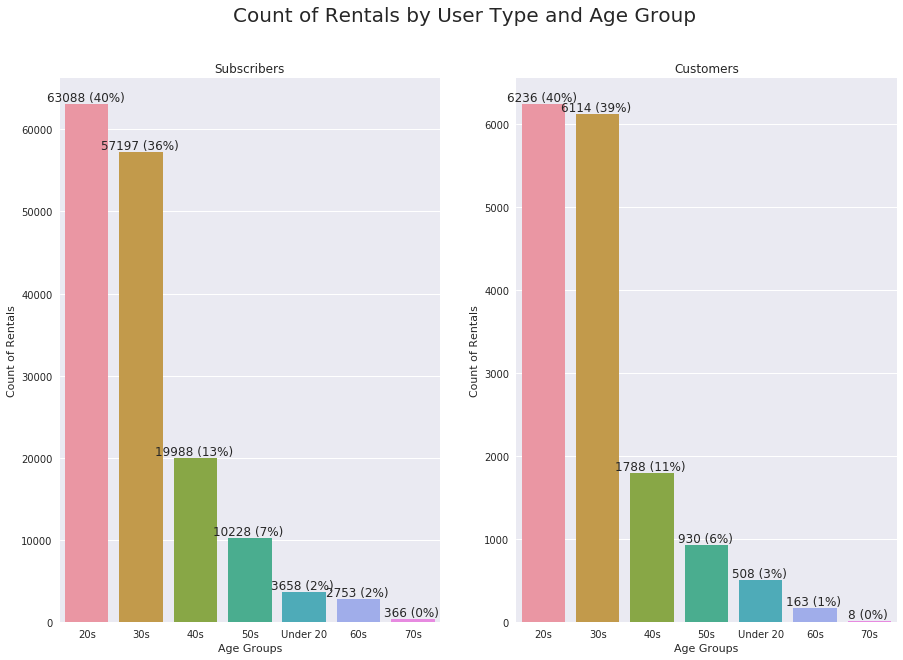

In [102]:
fig, ax = plt.subplots(1,2, figsize=(15, 10))

fig.suptitle('Count of Rentals by User Type and Age Group', fontsize=20);

# Subscribers
plt.subplot(1, 2, 1)
subscriber = df_clean.query('user_type == "Subscriber"')
sb.set(rc={"figure.figsize":(8, 8)})
ax = sb.countplot(x = subscriber['age_group'], order = subscriber['age_group'].value_counts().index)
ax.set_xlabel('Age Groups');
ax.set_ylabel('Count of Rentals');
ax.set_title('Subscribers');

abs_values = subscriber['age_group'].value_counts(ascending=False)
rel_values = subscriber['age_group'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

for p, label in zip(ax.patches, lbls):
    ax.annotate(label, (p.get_x()+0.375, p.get_height()+0.15),  horizontalalignment='center', verticalalignment='middle')

#Customers
plt.subplot(1, 2, 2)
customer = df_clean.query('user_type == "Customer"')
sb.set(rc={"figure.figsize":(8, 8)})
ax = sb.countplot(x = customer['age_group'], order = customer['age_group'].value_counts().index)
ax.set_xlabel('Age Groups');
ax.set_ylabel('Count of Rentals');
ax.set_title('Customers');

abs_values = customer['age_group'].value_counts(ascending=False)
rel_values = customer['age_group'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

for p, label in zip(ax.patches, lbls):
    ax.annotate(label, (p.get_x()+0.375, p.get_height()+0.15),  horizontalalignment='center', verticalalignment='middle')

> The trend is similar across both age groups in each user type. Customers in their 30s is slightly higher than Subscribers in their 30s.

### Duration of Rental and Day of the Week

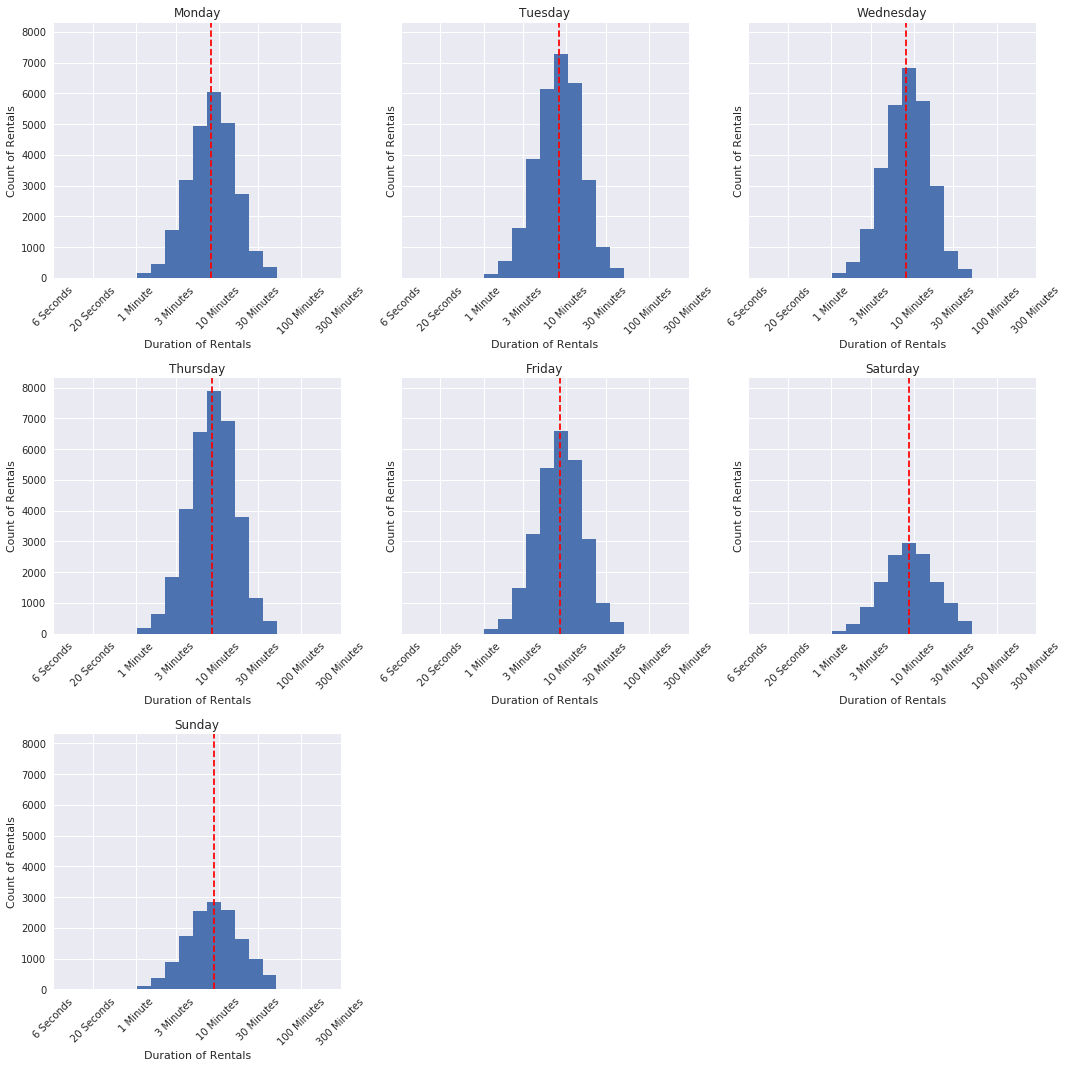

In [103]:
g = sb.FacetGrid(data = df_clean, col = 'day_of_rental', size = 5, col_wrap = 3, margin_titles = True)

def plot_mean(log_duration,**kwargs):
    m = log_duration.mean()
    plt.axvline(m, **kwargs)

g.map(plt.hist, "log_duration")
g.set(xticks = log_trans(np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])))
g.set(xticklabels = (['6 Seconds', '20 Seconds', '1 Minute', '3 Minutes','10 Minutes', '30 Minutes', 
                    '100 Minutes','300 Minutes']))

titles = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

g.map(plot_mean, 'log_duration', color="red", linestyle="dashed") 

axes = g.axes.flatten()
for ax,title in zip(g.axes.flatten(),titles):
    ax.set_title(title)
    ax.set_xlabel("Duration of Rentals")
    ax.set_ylabel("Count of Rentals")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    for tick in ax.get_xticklabels():
        tick.set_visible(True)
    
plt.tight_layout()

In [47]:
#standard deviation shows more spread on the weekends than during the week
df_clean.groupby('day_of_rental')['log_duration'].std()

day_of_rental
Monday       0.280302
Tuesday      0.271720
Wednesday    0.273177
Thursday     0.276726
Friday       0.276006
Saturday     0.312242
Sunday       0.319072
Name: log_duration, dtype: float64

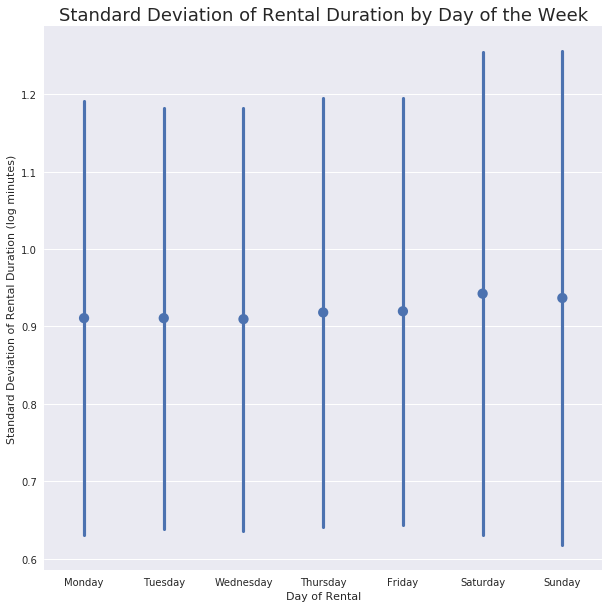

In [64]:
#and is demonstrated in this visualization
ax = sb.pointplot(data=df_clean, x='day_of_rental', y='log_duration', color=base_color, ci='sd', linestyles="");
ax.set_ylabel('Standard Deviation of Rental Duration (log minutes)');
ax.set_xlabel('Day of Rental');
ax.set_title('Standard Deviation of Rental Duration by Day of the Week', fontsize = 18);

> This makes sense; use during the week has already been shown to be consistent and that weekend use is much more varied. This visualization is additional support of that idea.

### Rental Hour and Duration

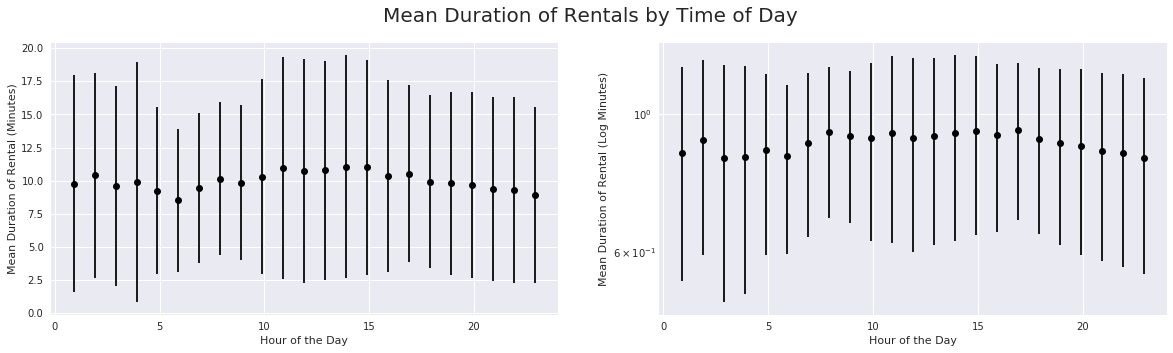

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(20, 5))
fig.suptitle('Mean Duration of Rentals by Time of Day', fontsize=20);

# Rental Minutes
plt.subplot(1, 2, 1) 
bin_edges = np.arange(0.6, 23+0.2, 0.2)
bin_centers = bin_edges[:-1] + 0.1

hours_binned = pd.cut(df_clean['rental_hour'], bin_edges, include_lowest = True)
hours_binned

minutes_mean = df_clean['rental_minutes'].groupby(hours_binned).mean()
minutes_std = df_clean['rental_minutes'].groupby(hours_binned).std()

plt.errorbar(x=bin_centers, y=minutes_mean, yerr=minutes_std, fmt='o', color = 'black')
plt.xlabel('Hour of the Day');
plt.ylabel('Mean Duration of Rental (Minutes)');

#Log Duration
plt.subplot(1, 2, 2) 
bin_edges = np.arange(0.6, 23+0.2, 0.2)
bin_centers = bin_edges[:-1] + 0.1

hours_binned = pd.cut(df_clean['rental_hour'], bin_edges, include_lowest = True)
hours_binned

minutes_mean = df_clean['log_duration'].groupby(hours_binned).mean()
minutes_std = df_clean['log_duration'].groupby(hours_binned).std()


plt.errorbar(x=bin_centers, y=minutes_mean, yerr=minutes_std, fmt='o', color = 'black');
plt.xlabel('Hour of the Day');
plt.ylabel('Mean Duration of Rental (Log Minutes)');
plt.yscale('log');

> The duration of rental pattern is similar in both observations. 

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

*  Customers use the bikes with more frequency throughout the week, whereas Subscribers are typically using the bikes during the week more often than the weekends.

*  Subscribers tend to use the bikes for quick trips (under 10 minutes), whereas Customers are using the bikes for longer purposes (over 10 minutes).

*  Regardless of the day of the week, the median rental time was consistent, even if the spread was greater on the weekends. Mean and Median rental duration is longer on the weekends, but not by much. This is clearly demonstrated in the log duration view of the box plot.

*  Users identifying as Female skewed younger than the other two identity groups. They also averaged more minutes than the Male group, but rented the bikes for a similar length of time on average to the Other group.

*  There were no obvious differences across member gender groups throughout the week in terms of number of rentals per day.

*  Median duration was consistent across all age groups. The Under 20s group demonstrated more variance in rental time, which makes me wonder if that group is also mostly females.

*  Age does not appear to be a factor in rental duration, all age groups broadly rent the bikes for similar lengths of time. The Under 20 group had more variation in length of rentals and the median rental time was slightly higher in the 60s age group.

*  In terms of customer type and age group, customers in the Under 20 and 30s age groups rented bikes at a higher rate than subscribers in the same groups.

*  Duration of use during the week is consistent and there is more variance in duration of use on the weekends. Users are renting for longer periods during that time. Rental duration and time of day is also reflective of the idea that weekday use is for commuting and weekend use is likely for a different purpose.


### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

*  More so the lack of a relationship - it doesn't seem that age is really as big of a factor on its own. I think it will be more of an influencing factor in the multivariate exploration. I thought that age would have a larger impact on rentals.

## Multivariate Exploration


### Age, Gender, User Type

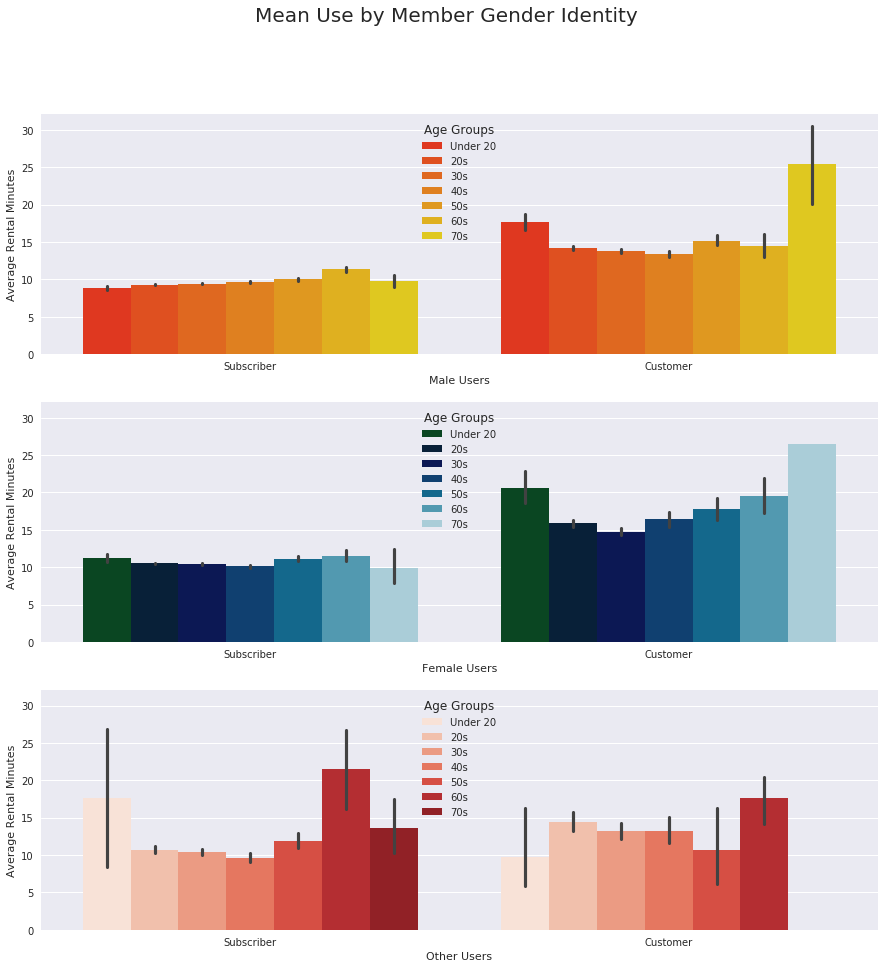

In [50]:
fig, ax = plt.subplots(3,1, sharey = True, figsize=(15, 15))

fig.suptitle('Mean Use by Member Gender Identity', fontsize=20);

# males
#plt.subplot(3, 1, 1)
sb.barplot(data = df_clean.query('member_gender == "Male"'), x = 'user_type', 
                       y = 'rental_minutes', hue = 'age_group', palette = 'autumn', ax = ax[0]);
ax[0].set_ylabel('Average Rental Minutes');
ax[0].set_xlabel('Male Users');
ax[0].legend(title = 'Age Groups', loc = 'upper center');

# females
#plt.subplot(3, 1, 2)
sb.barplot(data = df_clean.query('member_gender == "Female"'), x = 'user_type', 
                       y = 'rental_minutes', hue = 'age_group', palette = 'ocean', ax = ax[1]);
ax[1].set_ylabel('Average Rental Minutes');
ax[1].set_xlabel('Female Users');
ax[1].legend(title = 'Age Groups', loc = 'upper center');

# other
#plt.subplot(3, 1, 3)
sb.barplot(data = df_clean.query('member_gender == "Other"'), x = 'user_type', 
           y = 'rental_minutes', hue = 'age_group', palette = 'Reds', ax = ax[2]);
ax[2].set_ylabel('Average Rental Minutes');
ax[2].set_xlabel('Other Users');
ax[2].legend(title = 'Age Groups', loc = 'upper center');

> This visualization supports the idea that Customers rent the bikes for longer periods of time, on average. It also shows that Male-identifying Subscribers use the bikes for longer rental periods as age increases. Female-identifying Subscribers have a higher average duration in the youngest group, which declines through the 40s age group and then increases again with the older group of 50s and 60s.

### User Type by Gender Identity and Mean Rental Duration

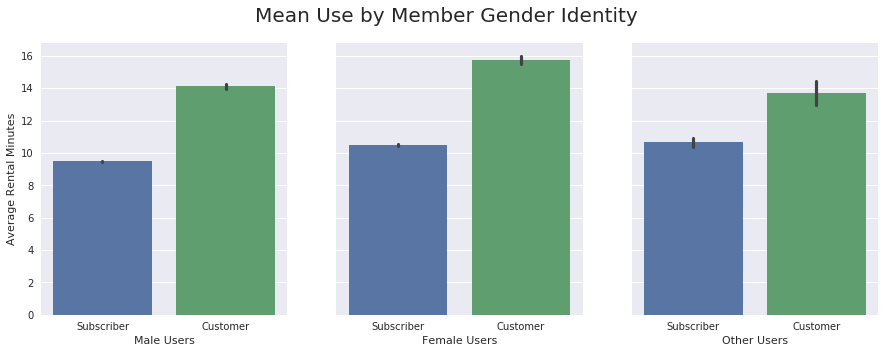

In [51]:
fig, ax = plt.subplots(1,3, sharey = True, figsize=(15, 5))

fig.suptitle('Mean Use by Member Gender Identity', fontsize=20);

# males  
sb.barplot(data = df_clean.query('member_gender == "Male"'), x = 'user_type', 
           y = 'rental_minutes', ax = ax[0]);
ax[0].set_ylabel('Average Rental Minutes');
ax[0].set_xlabel('Male Users');


# females
sb.barplot(data = df_clean.query('member_gender == "Female"'), x = 'user_type', 
           y = 'rental_minutes', ax = ax[1]);
ax[1].set_ylabel(' ');
ax[1].set_xlabel('Female Users');

# other
sb.barplot(data = df_clean.query('member_gender == "Other"'), x = 'user_type', 
           y = 'rental_minutes', ax = ax[2]);
ax[2].set_ylabel(' ');
ax[2].set_xlabel('Other Users');

> Again, regardless of gender identity, Customers rent the bikes for longer periods of time.

### Duration, Day of the Week, and User Type

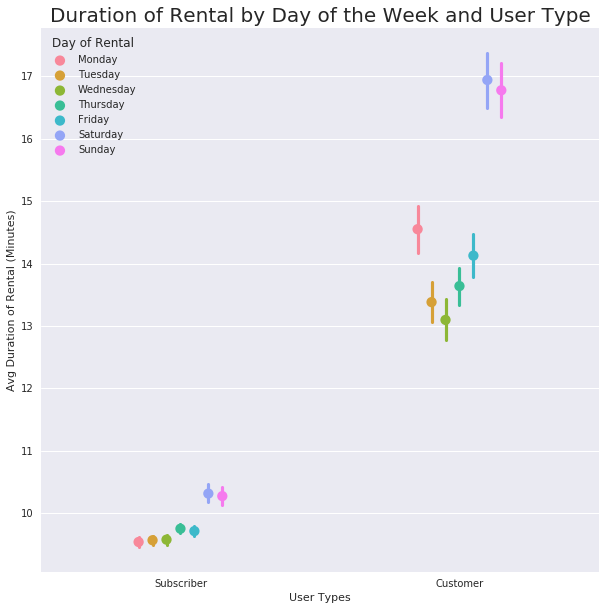

In [62]:
sb.set(rc={"figure.figsize":(10,10)})
ax = sb.pointplot(data = df_clean, x = 'user_type', y = 'rental_minutes', hue = 'day_of_rental',
                  dodge = 0.3, linestyles = "")
ax.set_xlabel('User Types');
ax.set_ylabel('Avg Duration of Rental (Minutes)');
plt.legend(title = 'Day of Rental');
plt.title('Duration of Rental by Day of the Week and User Type', fontsize = 20);

> Subscribers' rental behavior is quite predictable, whereas Customer's use can be assumed to be longer, but there is some variation in the average duration of rental.

### Duration, Day of the Week, Gender Identity

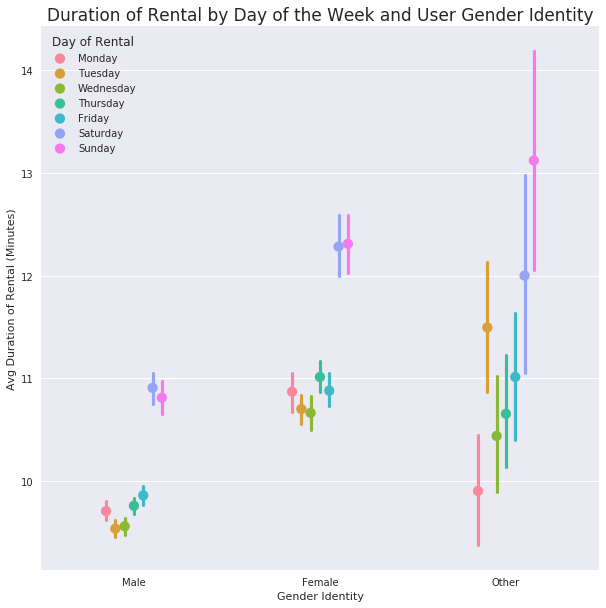

In [58]:
#I am using the rental minutes value to see any trends

ax = sb.pointplot(data = df_clean, x = 'member_gender', y = 'rental_minutes', hue = 'day_of_rental',
                  dodge = 0.3, linestyles = "")
ax.set_xlabel('Gender Identity');
ax.set_ylabel('Avg Duration of Rental (Minutes)');
plt.legend(title = 'Day of Rental');
plt.title('Duration of Rental by Day of the Week and User Gender Identity', fontsize=17);

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


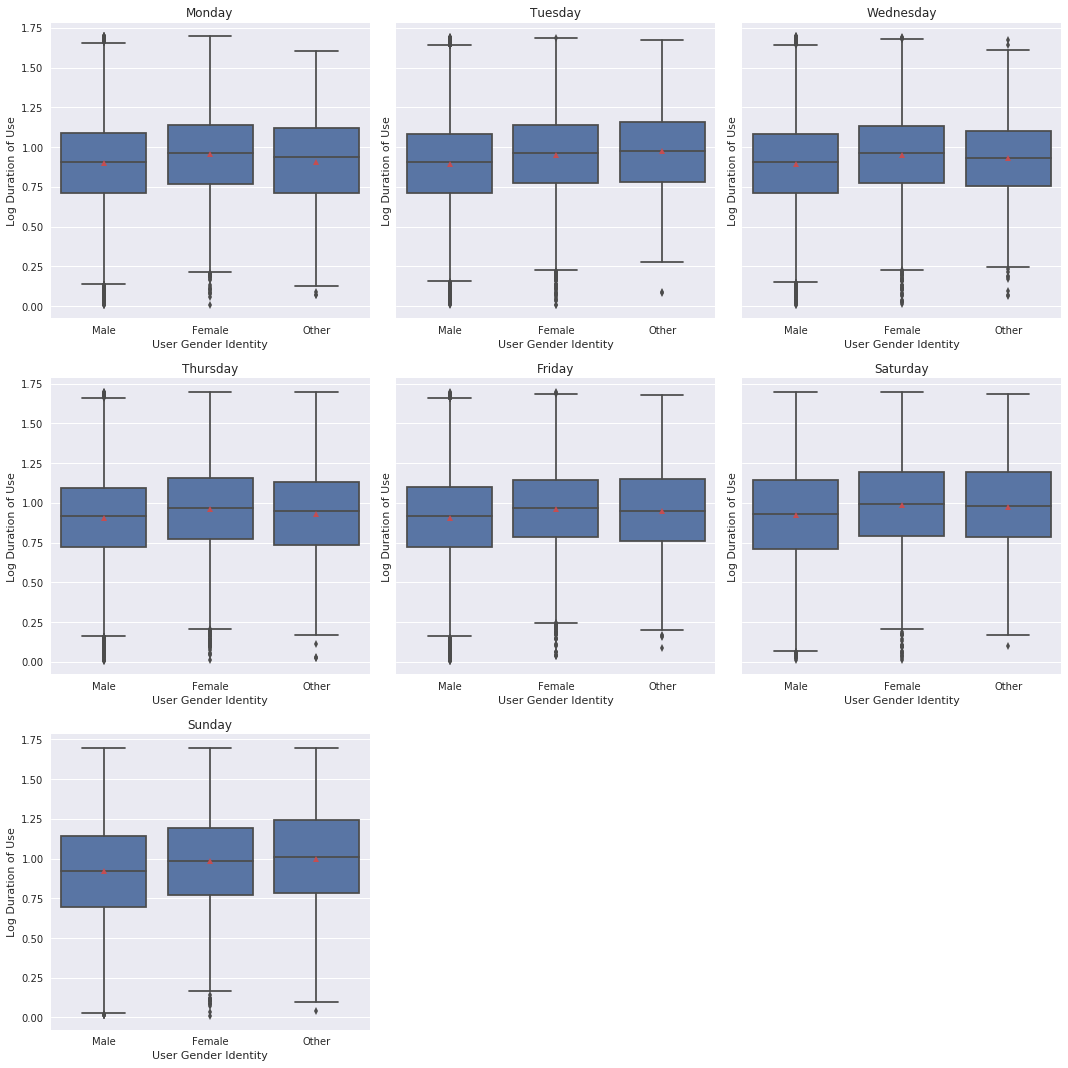

In [60]:
#I need to use my log duration value to get a better view of the data to look for any trends
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


g = sb.FacetGrid(data = df_clean, col = 'day_of_rental', col_order = day_order, size = 5, col_wrap = 3)
g.map(sb.boxplot, 'member_gender', 'log_duration', showmeans = True);


titles = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


axes = g.axes.flatten()
for ax,title in zip(g.axes.flatten(),titles):
    ax.set_title(title)
    ax.set_xlabel("User Gender Identity")
    ax.set_ylabel("Log Duration of Use")
    ax.set_xticklabels(ax.get_xticklabels())

    for tick in ax.get_xticklabels():
        tick.set_visible(True)
    
plt.tight_layout()

> These visualizations show how the typical user is the most predictable (male-identifying); Female-identifying users rent for longer with increasing variation, and other-identifying rent for the longest with most variation. All groups show similar usage trends of less time during the week and longer rentals on weekends.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?



*  Customers use the bikes for longer periods of time regardless of gender identity. This is consistent across each age group between people who identify as males and females, but there is much more uncertaintly when it comes to people who identify as other. That group of people has varying rental duration averages in both the subscriber and customer user types.

*  Male identifying Subscribers use the bikes for longer rentals as age increases.

*  Female identifying Subscribers have a higher average duration in the youngest group, which declines through the 40s age group and then increases again with the older group of 50s and 60s.

*  Again, it is obvious that Subscribers are using the bikes for short periods of time each day, with an increase in average duration on the weekends, but Customers are renting for longer periods throughout the week, and also for longer periods on the weekends. Each day a Customer rents a bike, the average rental duration is much more variable and less predictable compared to Subscribers.

*  Gender Identity also indicates a simlar pattern, where in male-identifying users' rental duration during the week is the lowest with the least amount of variance. Female-identifying users are renting the bikes for longer average durations and with more variance than the male-identifying users. This trend continues to increase with the other-identifying users group; rentals are shorter during the week than on weekends, but the spread of average rental times is much greater than the other two.


### Were there any interesting or surprising interactions between features?

*  I really thought that the people who identified as Other would have also been comprised of more Customer users, but that wasn't the case.

## Conclusions
I started out this project looking to understand who the typical user is of the GoBike program. I did not have any particular pre-conceived notions of what this user would look like, but I am a little surprised nonetheless.

The users are overwhelmingly Subscribers (people with an annual/monthly membership), male-identifying, and in his early-30s. He most often using the bikes to commute to and from work during the week, and occasionally on the weekend. His use is fairly consistent and predictable.

What was surprising and most interesting was the characteristics of the other kinds of people using the bikes. Female-identifying users are younger and use the bikes, on average, for longer periods of time. There is also an increase in variation of average rental duration and they rent the bikes for longer on the weekends, too.

People who identified as Other showed the most variation in their use. While they were also overwhelmingly Subscribers, they had the least predictable pattern of use. Although, similarly to the other groups, duration of rentals during the week is shorter than weekends.

Customers (people who pay per use) skewed younger and rented the bikes for longer periods of time, on average.

It would be interesting to have more information, such as userID to see if there are Customers who are using the bikes often enough that they don't realize they could benefit from becoming Subscribers. Also, not every rental had a gender identity selected. It's entirely possible that casual users are not inputting that kind of information when they rent and Subscribers are. This dataset probably could be more useful to determine which station locations are being used the most or least and adjust availability based on those numbers.
